# Deep Learning &mdash; Assignment 2 (update 2020.09.10)

Second assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2020_

-----

**Names:** Ward Theunisse & Nienke Wessel

**Group:** 25

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Learn how to define and train a neural network with pytorch
2. Experiment with convolutional neural networks
3. Investigate the effect of dropout and batch normalization

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `sounddevice` to play audio,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [1]:
%matplotlib inline
import os
import numpy as np
from d2l import torch as d2l
import torch
from torch import nn
from scipy.io import wavfile

## 2.1 Digits dataset

The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**Use `git clone` to download the dataset.**

Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between 0 and 1 or between -1 and 1.

**Update the below code to normalize the data to a reasonable range**

In [2]:
samplerate = 8000
def load_waveform(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform,(0,size))[0:size]
    # Normalize waveform
    waveform = waveform/32768.0
    return waveform

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**Load the data into a variable `data`**

In [3]:
class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data = SpokenDigits("free-spoken-digit-dataset/recordings")
print(len(data))
print(len(data[0]))
print(len(data[0][0][0]))


#for i in range(0,100):
#    print(data.__getitem__(i)[1])
    
print(np.unique([data.__getitem__(i)[1] for i in range(len(data))]))

3000
2
6000
[0 1 2 3 4 5 6 7 8 9]


**Describe the dataset: how many samples are there, what is their dimensionality? How many classes are there?**

There are 3000 samples. A sample consists of a waveform and a class, so it has dimension 2. A waveform has dimension 6000 (as mentioned before in the exercise). 
There are 10 classes: 1 for each single digit.

Here is code to play samples from the dataset to give you an idea what it "looks" like.

In [4]:
import sounddevice as sd
def play(sample):
    sd.play(sample[0][0], samplerate)
    print(sample[1])
play(data[0])

tensor(2)


In [5]:
train_prop = 2/3
train_count = int(len(data) * train_prop)
train, test = torch.utils.data.random_split(data, [train_count, len(data)-train_count])

The code above is code to split the data into a training and test set. It uses 2/3 of the data for training.

**Discuss an advantage and disadvantage of using more of the data for training**

The testing becomes less accurate, as you're testing on less data.

However, your model will have more examples to learn from.

Finally, we split the data into batches:

In [6]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter  = torch.utils.data.DataLoader(test,  **data_params)

## 2.2 One dimensional convolutional neural network

We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**Complete the network architecture, look at the d2l book chapters 6 and 7 for examples**

In [7]:
net = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(), #L_out=5996
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=2998
    
    # DONE: Add three more convolutional layers, ReLU layers and pooling layers;
    #       doubling the number of channels each time
    # DONE: Your code here.
    
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(), #L_out=2994
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=1497
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(), #L_out=1493
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=746
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(), #L_out=742
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=371
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

**The first fully connected layer has input dimension 11872, where does that number come from?**

Hint: think about how (valid) convolutional layers and pooling layers with stride affect the size of the data.

It is the result of the flattening of 32 channels with a signal length of 371 each. This signal length is the result of the convolution layer decreasing the length by 4 (the kernel size - 1) each time, and the average pooling layer dividing it by 2 and rounding down.
(Note that this is a simplification of the general equations, for these specific layer settings)

**How many parameters are there in the model? I.e. the total number of weights and biases**

In [8]:
# DONE: Compute the number of parameters
# Hint: use net.parameters() and param.nelement()
total = 0
for el in net.parameters():
    #print("Size of current parameter group:",el.nelement())
    print(el.nelement())
    total+=el.nelement()
print("Total parameters:",total)

20
4
160
8
640
16
2560
32
1519616
128
8192
64
640
10
Total parameters: 1532090


**Suppose that instead of using convolutions, we had used only fully connected layers. How many parameters would be needed in that case approximately?**

An extreme amount more. Take for example the first convolution layer: it has 20 parameters from the 4 * 5 kernels, and 5 bias parameters. A fully connected layer at that stage would have been 6000 * 6000+6000=36006000 parameters.

Full back of the napkin calculation:

4 sets of layers of approx 36006000 parameters. It's not exact, since 
the AvgPool1d slightly decreases it.
The first linear layer will be from 6000 to 128 instead, so that will have 768128 (i.e. 6000 * 128+128) parameters. After that point the parameters counts will be the same as in the original network.

4 * ~36006000 + 768128 + 8192 + 64 + 640 + 10 = 144801034

This is around 95 times more parameters.

The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to chapter 6.6 and 7.1 of the book.

**How many epochs do you think are needed?**

Our dataset has 20 times less data than FashionMNIST, so we suggest we need a higher learning rate to get closer to the same amount of weight update per epoch.

If the amount of data being smaller is already compensated for in the learning rate, it is not immediately clear whether the amount of epochs can be lowered as would the case for "keeping the dataset the same size, but increasing the learning rate".

In [19]:
lr, num_epochs = 0.05, 20 # DONE: change

We will use the code from the d2l book to train the network.
In particular, the `train_ch6` function, defined in [chapter 6.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html#training). This function is available in the `d2l` library.
However, this function has a bug: it only initializes the weights for 2d convolutional layers, not for 1d convolutional layers.

**Make a copy of the train_ch6 function, and correct the error**

In [20]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')


**Now train the network.**

In [11]:
#print(net)

#train_ch6(net, train_iter, test_iter, num_epochs, lr)

**Is the training converged?**

If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.

In our initial tests we used many different learning rate settings (0.1, 0.001, 0.0001, 0.3, 0.5, 0.9, 0.95) and a set of epoch counts (2, 10, 20), inspired by the examples in the book. However, for each of these settings the resulting graph was pretty much horizontal.

After some more tests, it turned out that the learning curve of the network on this dataset with SGD is one that has a long very flat start which then at some point changes direction and converges in relatively little time.

For a learning rate of 0.03, training converges after roughly 110 epochs, with a resulting test accuracy of 0.74.

For a learning rate of 0.04, training converges after around 60 epochs, with a resulting test accuracy of 0.638.

For a learning rate of 0.05, training converges after around 60 epochs, with a resulting test accuracy of 0.699.

For a learning rate of 0.002, the network only really starts to make progress after ~330 epochs, and isn't converged at 500 epochs.

Do note that these results are partially dependent on initial weights, and those are randomized.

## 2.3 Questions and evaluation

**Does the network look like it is overfitting or underfitting?**

You could argue that it is overfitting in the sense that the model eventually achieves 100% training accuracy, with the training accuracy and test accuracy diverging meaningfully.

Interestingly, the highest test accuracy is also achieved when the highest training accuracy is achieved, so it also feels like the training set is not of necessary size to have the network learn to generalize well.

**Is what we have here a good classifier? Could it be used in a realistic application?**

Roughly 75 percent accuracy seems pretty okay, but also way to low for any realistic application. Getting one in four numbers wrong when speaking to a virtual assistant is unacceptably high.

**Do you think there is enough training data compared to the dimensions of the data and the number of parameters?**

It seems to small. If the training set was much larger, the test accuracy and training accuracy would diverge less, since the model would be less able to overfit since the overfit couldn't be encoded in this given amount of parameters.

**How could the classifier be improved?**

Increasing the size of the dataset seems like an easy answer. Training with an adaptive/momentum-based optimizer also seems like it would be better, since lower learning rates seem to lead to meaningfully better final results, but the amount of necessary epochs grows quite fast as well.

**The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing the voice of a new speaker? And if not, how could that be tested instead?**

No, since the speakers in the test set and training set overlap. It would be more representative if the speakers in the training set were all from new speakers.

## 2.4 Variations

One way in which the training might be improved is with dropout or with batch normalization.

**Make a copy of the network architecture below, and add dropout**

Hint: see [chapter 7.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

loss 2.310, train acc 0.096, test acc 0.098
511.8 examples/sec on cpu


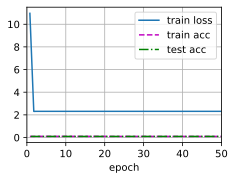

In [15]:
net_dropout = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(), #L_out=5996
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=2998   
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(), #L_out=2994
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=1497
    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(), #L_out=1493
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=746
    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(), #L_out=742
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=371
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, 10))

#train_ch6(net_dropout, train_iter, test_iter, num_epochs, lr)

**How does dropout change the results?**

The first noticeable difference is that training takes longer. Where the network with lr=0.05 would end its flat section around 30 epochs in. For the version with dropout this happens around epoch 60. This is understandable given the fact that dropout (especially when set as high as 0.5 probability) hinders the networks ability to predict and pass gradients. However, it should in theory lead to a more general model in the end.

Training and test accuracy still diverge, and test accuracy doesn't end up higher than the non-dropout version for the same learning rate (0.676 vs 0.699 for lr=0.05), which is disappointing to say the least.

(TODO: Why does this happen?)

The tail end of learning also takes a lot longer.

**Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.**

Hint: see [chapter 7.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

loss 0.005, train acc 1.000, test acc 0.750
501.3 examples/sec on cpu


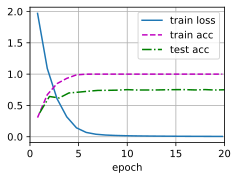

In [21]:
net_batchnorm = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.BatchNorm1d(4), nn.ReLU(), #L_out=5996
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=2998   
    nn.Conv1d(4, 8, kernel_size=5), nn.BatchNorm1d(8), nn.ReLU(), #L_out=2994
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=1497
    nn.Conv1d(8, 16, kernel_size=5), nn.BatchNorm1d(16), nn.ReLU(), #L_out=1493
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=746
    nn.Conv1d(16, 32, kernel_size=5), nn.BatchNorm1d(32), nn.ReLU(), #L_out=742
    nn.AvgPool1d(kernel_size=2, stride=2), #L_out=371
    nn.Flatten(),
    nn.Linear(11872, 128), nn.BatchNorm1d(128), nn.ReLU(),
    nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 10))

#train_ch6(net_batchnorm, train_iter, test_iter, num_epochs, lr)

**How does batch normalization change the results?**

Training happens a lot faster. The network for lr=0.05 converges in less than 10 epochs. The training and test accuracy still diverge, and seemingly a lot earlier in training than in the non-bach normalised version, though it happens at roughly the same level of accuracy in the traing process.

The reached accuracy is also a lot higher: For the network with 0.05 learning rate, the test accuracy becomes 0.750 vs 0.699, which is a signifcant improvement.

## 2.5 Bonus: feature extraction

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necesary to do manual feature extraction. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [ ]:
from python_speech_features import mfcc

def load_waveform_mfcc(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform,(0,size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**Implement a variation of the dataset that uses these features**

In [ ]:
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    # TODO: Your code here.
    pass

data_mfcc = SpokenDigitsMFCC(data_dir) # TODO: your data directory here
train_count_mfcc = int(len(data_mfcc) * train_prop)
train_mfcc, test_mfcc = torch.utils.data.random_split(data, [train_count_mfcc, len(data_mfcc)-train_count_mfcc])
train_iter_mfcc = torch.utils.data.DataLoader(train_mfcc, **data_params)
test_iter_mfcc  = torch.utils.data.DataLoader(test_mfcc,  **data_params)

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**Inspect the shape of the data, and define a new network architecture that accepts data with this shape**

In [ ]:
# Your code here.

**Train the network with the mfcc features.**

In [ ]:
# Your code here.

**Is there a neural-network based alternative to mfcc features?**

TODO: your answer here